In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


### Relevant Activation functions

In [ ]:
def ReLU(x):
    """Relu activation function
    Args:
        x (float): array of inputs
    Returns:
        y (float): Output
    """
    return np.maximum(x, 0)        # apply element wise maximum

def sigmoid(x):
    """Sigmoid activation function
    Args:
        x (float): Value to be processed
    Returns:
        y (float): Output
    """
    x = x.astype(float)
    y = 1.0 / (1 + np.exp(-x))
    return y


def tanh(x):
    """Sigmoid activation function
    Args:
        x (float): Value to be processed
    Returns:
        y (float): Output
    """
    y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    return y


def PReLU(x, alpha=0.01):                   # f(x) = max(0, x) + a*min(0, x)
    """Relu activation function
    Args:
        x (float): array of inputs
    Returns:
        y (float): Output
    """
    return np.maximum(x, 0) + alpha * np.minimum(x, 0)        # apply element wise maximum and minimum of array elements


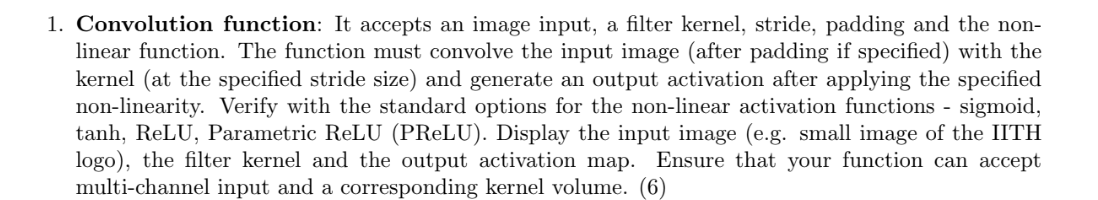

NOTE: OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. When you display an image loaded with OpenCv in matplotlib the channels will be back to front.

### Displaying the input image :-

In [ ]:
img = cv2.imread('iith_logo.jpg')

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()
print(RGB_img.shape)

# gray_img = cv2.imread('iith_logo.jpg', cv2.IMREAD_GRAYSCALE)
# plt.imshow(gray_img, cmap= 'gray')
# plt.show()
# gray_img.shape

In [ ]:
def image_region(image, n_filters, filter_height, filter_width, n_channels = 3, padding = (0, 0), stride=(1, 1)):           
    """
    A helper function for the convultion function .
    Extracting the patches of the image(input)
            according to the filter width and height.
     i.e generates all possible image regions using valid padding.
                                                                    """

    # Padding (p1, p2)
    p1 = padding[0]                             # along height 
    p2 = padding[1]                             # along width
    pad_img = np.pad(image, [(p1, ), (p2, ), (0, )], mode='constant')


    H, W, C = pad_img.shape
    h, w = filter_height, filter_width

    # stride 
    s1 = stride[0]
    s2 = stride[1]

#     i_ = -1
#     j_ = -1

    for k in range(C):
        for i in range(0, H - h + 1, s1):
            for j in range(0, W - w + 1, s2):
                img_patch = pad_img[:,:,k][i :( i + h), j :( j + w )]
                yield img_patch, i, j, k




def conv_fn(image, filter_height, filter_width, n_channels = 3, n_filters=1, padding = (0, 0), stride=(1, 1), act_fn = sigmoid):
    
    
    # Padding (p1, p2)
    p1 = padding[0]                             # along height 
    p2 = padding[1]                             # along width

    Hi, Wi , C  = image.shape

    H, W = Hi + p1, Wi + p2

    h, w = filter_height, filter_width
    D = n_filters                               # no. of filters = depth = D
    
    # Xavier initialization
    conv_filter = np.random.randn(1, filter_height, filter_width, n_channels)/(filter_height * filter_width)
    
    
    
    ###### Displaying the filter kernel #######
    plt.imshow((conv_filter[0,:,:,:]*255).astype(np.uint8))              
    plt.title('Filter kernel')
    print(conv_filter[0,:,:,:].shape)
    plt.show()
    
    
    biases = np.random.rand(H - h + 1, W - w + 1, D)
    conv_out = np.copy(biases)    

    for image_patch, i , j, k in image_region(image, n_filters, filter_height, filter_width, n_channels , padding , stride):
        conv_out[i, j] += np.sum(image_patch*conv_filter[:,:,:,k], axis = (1, 2))         # it is a D dimensional numpy array OUTPUT[]

        
        
    ######### ACTIVATION FUNCTION ########
    
    return  act_fn(conv_out)



In [ ]:
np.random.seed(5)
act_dict = {ReLU:"ReLU", PReLU:"PReLU", sigmoid:"sigmoid", tanh:"tanh"}

for act in act_dict:
    ## Conv_fn applied to the image : -
    out = conv_fn(RGB_img, 5, 5, 3, 1, (0, 0), (1, 2), act) 


    ######## Displaying the output activation map ###########

    print(out.shape)                    # (H-h+1) x (W-w+1) x (D)
    plt.imshow(out[:,:,:])              # 5 such 2D-arrays would be there
    plt.title(f'Output activation map using {act_dict[act]}')
    plt.show()


## Kindly scroll down the above cell to see the outputs using different activation functions

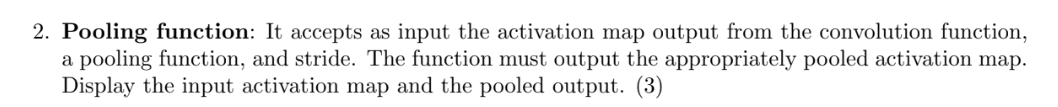

In [ ]:
def max_pool(image_patch):
    return np.amax(image_patch, axis = (0, 1))

def mean_pool(image_patch):
    return np.mean(image_patch, axis = (0, 1))


def image_region( image, filter_size , stride  , pool_fn):
    h = filter_size[0]
    w = filter_size[1]

    if stride == None:
        stride_ = (filter_size[0], filter_size[1])

    else:
        stride_ = (stride[0], stride[1])

    s1 = stride_[0]
    s2 = stride_[1]
    
    H, W = image.shape[0], image.shape[1]

    new_h = (H - h + s1) // s1
    new_w = (W - w + s2) // s2  


#   i_, j_ = -1, -1

    for i in range(0, new_h):
        for j in range(0, new_w):
            image_patch = image[(i*s1):(i*s1 + h), (j*s2):(j*s2 + w)]
            yield image_patch, i, j


def pooling_fn(image, filter_size = (2, 2) , stride = None , pool_fn = max_pool):
    H, W, D = image.shape                # D = number of filters = number of outputs = depth of outputs
    
    h = filter_size[0]
    w = filter_size[1]

    if stride == None:
        stride_ = (filter_size[0], filter_size[1])

    else:
        stride_ = (stride[0], stride[1])

    s1, s2 = stride_[0], stride_[1]

    new_h = (H - h + s1) // s1
    new_w = (W - w + s2) // s2 
    output = np.zeros( (new_h, new_w,  D))


    for image_patch, i, j in image_region(image, filter_size , stride, pool_fn):
        output[i, j] = pool_fn(image_patch)            # need to use self.pool_fn as no parameter pool_fn in method forward_prop()


    return output


## Display the input activation map and the pooled output

In [ ]:
print(f"Shape of the activation map output from the convolved layer: {out.shape}")
plt.imshow(out[:,:,:])              
plt.title('Activation map output(input)')
plt.show()


pooled_out = pooling_fn(out, (2,2), (2,2), pool_fn=max_pool)

# Depth is unchannged i.e 20 in this case while  W -> new_w,
print(f"Shape of the activation map output from the convolved layer: {pooled_out.shape}")                      
plt.imshow(pooled_out[:,:,:])
plt.title('Pooled output')
plt.show()

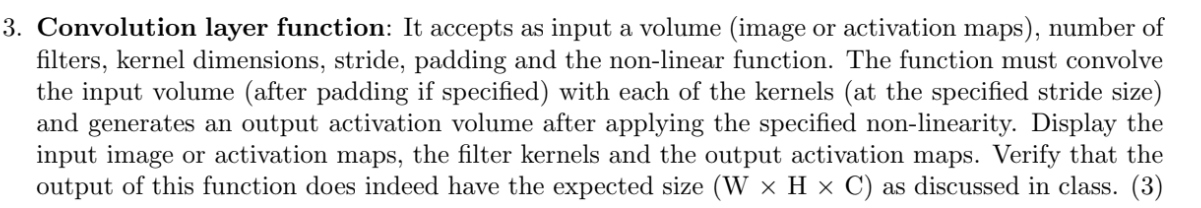

In [ ]:
class Conv_op:
    
    def __init__(self, n_filters, filter_height, filter_width, n_channels = 3, padding = (0, 0), stride=(1, 1)):
        
        """Constructor for the Convolution layer. Takes the number of filters, filter size,
            number of channels, desired padding, and desired stride as input.
                                                                                            """   
        self.n_channels = n_channels
        self.padding = padding                                 # padding = (p1, p2)
        self.stride= stride                                    # stride = (s1, s2) 
        self.n_filters = n_filters
        self.filter_height = filter_height
        self.filter_width = filter_width
        
        # Xavier initialization
        self.conv_filter = np.random.randn(n_filters, filter_height, filter_width, n_channels)/(filter_height * filter_width)
     

    def plot_kernels(self, n_filters):
        """ Displaying first 4 filter kernels(if more than 5) """        
        
        conv_filter = self.conv_filter   
        for i in range(min(4, n_filters)):            
            plt.subplot(2, 2, i+1)
            plt.imshow((conv_filter[i,:,:,:]*255).astype(np.uint8))              
            plt.title(f'Filter kernel : {i}')
            
        plt.suptitle("Plot of some Filter kernels")
        plt.tight_layout()
        plt.show()
       
    
    def image_region(self, image):            # a generator NOT a function, memory efficient, as they produce one output at a time.
        """
        Extracting the patches of the image(input)
                according to the filter width and height.
         i.e generates all possible image regions using valid padding.
                                                                        """
        self.image = image
        
        # Padding (p1, p2)
        p1 = self.padding[0]                             # along height 
        p2 = self.padding[1]                             # along width
        pad_img = np.pad(image, [(p1, ), (p2, ), (0, )], mode='constant')
        
        
        H, W, C = pad_img.shape
        h, w = self.filter_height, self.filter_width
        
        # stride 
        s1 = self.stride[0]
        s2 = self.stride[1]
        
        i_ = -1
        j_ = -1
        
        for k in range(C):
            for i in range(0, H - h + 1, s1):
                for j in range(0, W - w + 1, s2):
                    img_patch = pad_img[:,:,k][i :( i + h), j :( j + w )]
                    yield img_patch, i, j, k
                           
    
    def forward_prop(self, image, act_fn, padding = (0, 0)):     
        # Padding (p1, p2)
        p1 = padding[0]                             # along height 
        p2 = padding[1]                             # along width
        
        Hi, Wi , C  = image.shape
        
        H, W = Hi + p1, Wi + p2
        
        h, w = self.filter_height, self.filter_width
        D = self.n_filters                               # no. of filters = depth = D
           
        self.biases = np.random.rand(H - h + 1, W - w + 1, D)
        conv_out = np.copy(self.biases)
        
        for image_patch, i , j, k in self.image_region(image):
            conv_out[i, j] += np.sum(image_patch*self.conv_filter[:,:,:,k], axis = (1, 2))         # it is a D dimensional numpy array OUTPUT[]
        
        
        # Apply Activation function element wise 
        return act_fn(conv_out)
            
        

In [ ]:
# Plot the input / activation map:
plt.imshow(RGB_img)
plt.title("Input/activation map")
plt.show()

# Declare an object for the Conv_op class
conn = Conv_op(16, 5, 5, 3, (0, 0), (1, 2))

# Plot the filter kernels
conn.plot_kernels(16)

conv_out = conn.forward_prop(RGB_img, ReLU)

# Verification
print(f"The output of this function have the size {conv_out.shape} and hence verified it is indeed the same as taught in class")                         # (H-h+1) x (W-w+1) x (D)

# Plot one sample output activation map
plt.imshow(conv_out[:,:,3])                   # 16 such 2D-arrays would be there
plt.title(f'Output activation map in 3rd channel')
plt.show()



- Hence, the shape of the output of the convolution function output indeed have the expected size of (W X H X C) as discussed in class.

### Plot some of the output channels  :-

In [ ]:
for i in range(3, 6):
    plt.title(f'Output activation map in {i+1}th channel')
    plt.imshow(conv_out[:,:,i])
    plt.show()

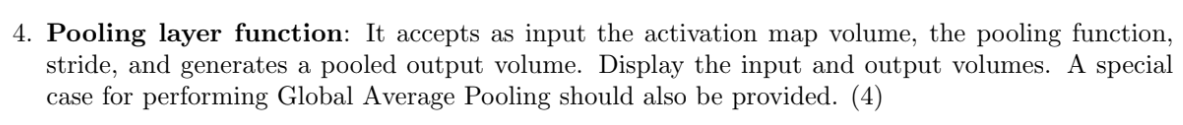

### The convolutional layers construct/extract features, and the pooling layers compress them to a lower fidelity
- A max-pool layer compressed by taking the maximum activation in a block. If you have a block with mostly small activation, but a small bit of large activation, you will loose the information on the low activations. Think of this as saying "this type of feature was detected in this general area".

- A mean-pool layer compresses by taking the mean activation in a block. If large activations are balanced by negative activations, the overall compressed activations will look like no activation at all. On the other hand, you retain some information about low activations in the previous case.

- The depth dimension remains unchanged. But width and height changes to 


In [ ]:
def max_pool(image_patch):
    return np.amax(image_patch, axis = (0, 1))

def mean_pool(image_patch):
    return np.mean(image_patch, axis = (0, 1))    
    

class Pooling2D:
    def __init__(self, filter_size=(2, 2) , stride = None , pool_fn = max_pool, global_pool=False):
        """Constructor for the Pooling layer. Takes the filter size,
            desired stride, ppoling function to be used, and if GAP has to be applied or not

        Args:
            filter size (tuples): size of the filters
            stride (tuple): stride, if none then same as filter size
            pool_fn (function): pooling function to be used
            global_pool(Boolean) : if GAP has to applied 
        """
        
        self.filter_height = filter_size[0]
        self.filter_width = filter_size[1]
        self.pool_fn = pool_fn
        self.global_pool = global_pool
        
        if(global_pool == True):
            self.pool_fn = mean_pool
        
        if stride == None:
            self.stride_ = (filter_size[0], filter_size[1])
        
        else:
            self.stride_ = (stride[0], stride[1])
        
        
    def image_region(self, image):
        """
        Extracting the patches of the image(input)
                according to the filter width and height, and valid stride.
         i.e generates all possible image regions accordingly.
                                                                        """
        
        H, W = image.shape[0], image.shape[1]

        if self.global_pool == False:
            h = self.filter_height
            w = self.filter_width

            s1 = self.stride_[0]
            s2 = self.stride_[1]
            
        else:
            h, w = H, W
            s1, s2 = 1, 1
            
        new_h = (H - h + s1) // s1
        new_w = (W - w + s2) // s2  
                
        self.image = image
    
        for i in range(0, new_h):
            for j in range(0, new_w):
                image_patch = image[(i*s1):(i*s1 + h), (j*s2):(j*s2 + w)]
                yield image_patch, i, j
        
    
    def forward_prop(self, image):
        H, W , D = image.shape                # D = number of filters = number of outputs = depth of outputs
        
        if self.global_pool == False:
            h = self.filter_height
            w = self.filter_width

            s1 = self.stride_[0]
            s2 = self.stride_[1]
            
        else:
            h, w = H, W
            s1, s2 = 1, 1
        
        new_h = (H - h + s1) // s1
        new_w = (W - w + s2) // s2 
        output = np.zeros( (new_h, new_w,  D))
        
        for image_patch, i, j in self.image_region(image):
            output[i, j] = self.pool_fn(image_patch)            # need to use self.pool_fn as no parameter pool_fn in method forward_prop()

            
        return output
        

In [ ]:
print(f"Shape of the activation map output from the convolved layer: {conv_out.shape}")
plt.imshow(conv_out[:,:,2])              
plt.title('Activation map input at layer 2')
plt.show()


pool = Pooling2D((2,2), (2,2), pool_fn=max_pool)
pooled_out = pool.forward_prop(conv_out)
print(pooled_out.shape)                       # Depth is unchannged i.e 16 in this case while  W -> new_w,


# Depth is unchannged i.e 16 in this case while  W -> new_w, H -> new_h
print(f"Shape of the pooled map output : {pooled_out.shape}")                      
plt.imshow(pooled_out[:,:,3])
plt.title('Pooled output (layer 3) for illustration')
plt.show()

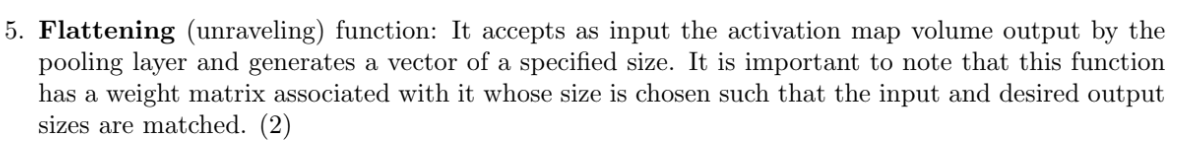

In [ ]:
def flattening(input_volume, output_size):
    """ A function used to flatten an input volume(outputed by the pooling layer)  
        to a output vector of the specified output size. """
    
    ## Decoding the input volume
    H, W, C = input_volume.shape
    
    
    x = np.ones(C)
    y = np.ones(W)
    
    # A1 = (input_volume @ x)
    A1 = np.matmul(input_volume, x)
    # A2 = (A1 @ y)
    A2 = np.matmul(A1, y)

    
    # Weight matrix associated which is to be learnt : size according to the input volume and desired output size
    weights = np.random.rand(output_size, H)  
    
    # output = W @ A2
    flattened_output = np.matmul(weights, A2) 
    
    return flattened_output
        
    

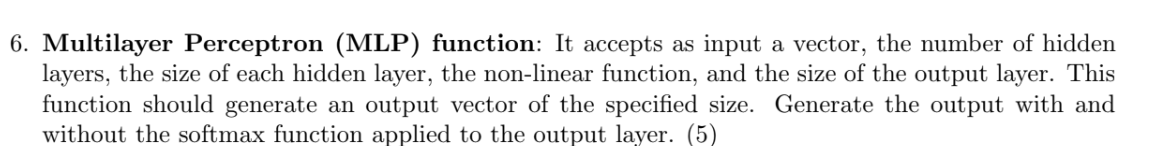

In [ ]:
class MLP:
    
    def __init__(self, input_vector, n_hidden = 2, hidden_layers = [32 , 32 ], num_outputs = 10, act_fn = sigmoid, softmax = True):
        """Constructor for the MLP. Takes the input vector,
            a variable number of hidden layers, and desired number of outputs, 
            activation function to be used and if softmax has to be applied at the last layer

        Args:
            num_inputs (int): Number of inputs
            hidden_layers (list): A list of ints for the hidden layers
            num_outputs (int): Number of outputs
        """
        
        self.input_vector = input_vector
        self.num_inputs = np.size(input_vector)                      
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs
        self.act_fn = sigmoid
        self.softmax = softmax
        
        # create a generic representation of the layers
        layers = [self.num_inputs] + hidden_layers + [num_outputs]
        
        bias = []
        weights = []
        for i in range(len(layers) - 1):
            w = np.random.rand(layers[i], layers[i + 1])
            b = np.random.rand(layers[i + 1])
            weights.append(w)
            bias.append(b)
        
        self.weights = weights
        self.bias = bias

    
    
    def _sigmoid(self, x):
        """Sigmoid activation function
                   Args: x (float): Value to be processed
            Returns: y (float): Output
        """
            
        y = 1.0 / (1 + np.exp(-x))
        return y
    
    
    
    def _softmax(self, output):
        """Softmax activation function
                   Args: output (float): Value to be processed
            Returns: y (float): Output
        """
            
        exp_out = np.exp(output)
        
        return exp_out/np.sum(exp_out, axis = 0)
    
    
    def forward_propagate(self, inputs):
        """Computes forward propagation of the network based on input signals.

        Args:
            inputs (ndarray): Input signals
        Returns:
            activations (ndarray): Output values
        """
            
        weights = self.weights
        bias = self.bias

        # the input layer activation is just the input itself
        activations = inputs

        # iterate through the network layers
        for i in range(len(weights)):

            # calculate matrix multiplication between previous activation and weight matrix
            net_inputs = np.dot(activations, weights[i]) + bias[i] 

            if(i < len(weights) - 1):
                # apply the activation function
                activations = self.act_fn(net_inputs)


            if(i == len(weights) - 1) and (self.softmax == True):
                activations = self._softmax(net_inputs)



        # return output layer activation
        return activations
        
        

### Sample run to check if the MLP is producing the desired output  - 

In [ ]:
# set random values for network's input
inputs = np.random.rand(5)

# create a Multilayer Perceptron
mlp = MLP(inputs, 5, [3, 3], 3)

# perform forward propagation
output = mlp.forward_propagate(inputs)

print("Network inputs are: {} and its dimension is {} \n".format(inputs, inputs.shape))
print("Network activation: {} and its shape is {}".format(output, output.shape))

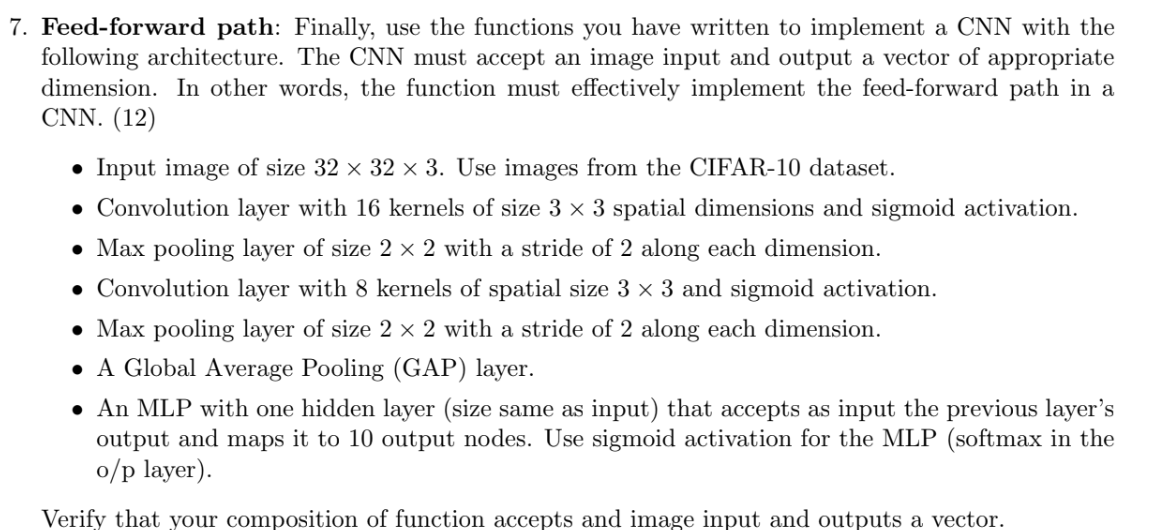

### CIFAR-10 Photo Classification Dataset
CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc. The class labels and their standard associated integer values are listed below.

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck



### Illustration of data imported from cifar10 :-

In [ ]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i])

# show the figure
plt.show()

In [ ]:
class feedForward:
    
    def convlayer1(self, image):
        """Convolution layer with 16 kernels of size 3 x 3 spatial dimensions
        and sigmoid activation. """

        # Declare an object for the Conv_op class
        conn = Conv_op(16, 3, 3, 3)                # default stride and padding

        conv_out = conn.forward_prop(image, sigmoid)
        
        return conv_out
       
    
    def maxpoollayer1(self, image):
        """ Max-pooling layer of size 2 x 2 with a stride (2,2)  """
        
        conv_out = image
        pool = Pooling2D((2,2), (2,2), pool_fn=max_pool)
        pooled_out = pool.forward_prop(conv_out)

        return pooled_out
    
    
    
    def convlayer2(self, image):
        """Conv layer with 8 kernels of spatial size 3x3 and sigmoid activation"""
        
        pooled_out = image
        # Decoding the number of channels we need to pass as parameter 
        # For that we need the shape of the pooled output, which essentially is the input to this Conv layer
        H, W, C = pooled_out.shape

        conn2 = Conv_op(8, 3, 3, C)                           # default stride and padding
        conv_out2 = conn2.forward_prop(pooled_out, sigmoid)
        
        
        return conv_out2
    

    def maxpoollayer2(self, image):
        """ Max-pooling layer of size 2 x 2 with a stride (2,2)  """
        
        conv_out2 = image
        pool2 = Pooling2D((2,2), (2,2), pool_fn=max_pool)
        pooled_out2 = pool2.forward_prop(conv_out2)
    
        return pooled_out2
    
    
    
    def GAPlayer(self, image):
        """ Applies global pooling to the input to this GAP layer ."""
        
        pooled_out2 = image
        globalPool = Pooling2D(global_pool=True)
        global_pooled_out = globalPool.forward_prop(pooled_out2)
        N = global_pooled_out.shape[2]
        global_pooled_out_reshaped = global_pooled_out.reshape(N)    
        
        return global_pooled_out_reshaped
    
    
    
    def mlp(self, image):
        """ MLP with 1 hidden layer(with size same as the input layer) 
                        and 10 output nodes. """
        
        global_pooled_out_reshaped = image
        
        # Shape of the input layer 
        N = global_pooled_out_reshaped.shape[0]

        # create a MLP object
        mlp = MLP(global_pooled_out_reshaped, 1, [N], 10, sigmoid, True)

        final_op = mlp.forward_propagate(global_pooled_out_reshaped)
        
        return final_op
    
    


## Illustration of all the layers defined as methods in the class feedForward : -

In [ ]:
nn = feedForward()
conv_out = nn.convlayer1(trainX[2])

plt.imshow(trainX[2])
plt.title("Input image")
plt.show()

# Plot one sample output activation map
plt.imshow(conv_out[:,:,2])                   # 16 such 2D-arrays would be there
plt.title(f'Output activation map of the image in 2nd channel')
plt.show()


In [ ]:
pooled_out = nn.maxpoollayer1(conv_out)
print(f"Shape of the input to the pooling layer: {conv_out.shape}")
print(f"Shape of the pooled map output : {pooled_out.shape}")    # Depth is unchannged i.e 16 in this case while  W -> new_w,

plt.imshow(pooled_out[:,:,2])
plt.title('Pooled output (channel 2) for illustration')
plt.show()

In [ ]:
conv_out2 = nn.convlayer2(pooled_out)
print(f"Shape of the input to the pooling layer: {pooled_out.shape}")
print(f"Hence, the shape of the convolved map output: {conv_out2.shape}")

In [ ]:
pooled_out2 = nn.maxpoollayer2(conv_out2)
print(f"Shape of the input to the pooling layer: {conv_out2.shape}")
print(f"Shape of the pooled map output : {pooled_out2.shape}")      # Depth is unchannged i.e 8 in this case while  W -> new_w,

In [ ]:
global_pooled_out_reshaped = nn.GAPlayer(pooled_out2) 
print(f"Shape of the input to the global pooling layer: {pooled_out2.shape}")
print(f"Shape of the global pooled output reshaped to 1D: {global_pooled_out_reshaped.shape}")

In [ ]:
final_op = nn.mlp(global_pooled_out_reshaped)
print(f"Shape of the input to the MLP: {global_pooled_out_reshaped.shape}")
print(f"Shape of the final output : {final_op.shape}")
print(f"The final output is: {final_op}")

### Ans : The above verifies that the function feed forward takes as input an image and outputs a vector
 Hence, it is verified that the Feed forward path specified in Q7 takes as input a 32 x 32 x 3 image and indeed outputs a vector of desired shape which was 10 in this case

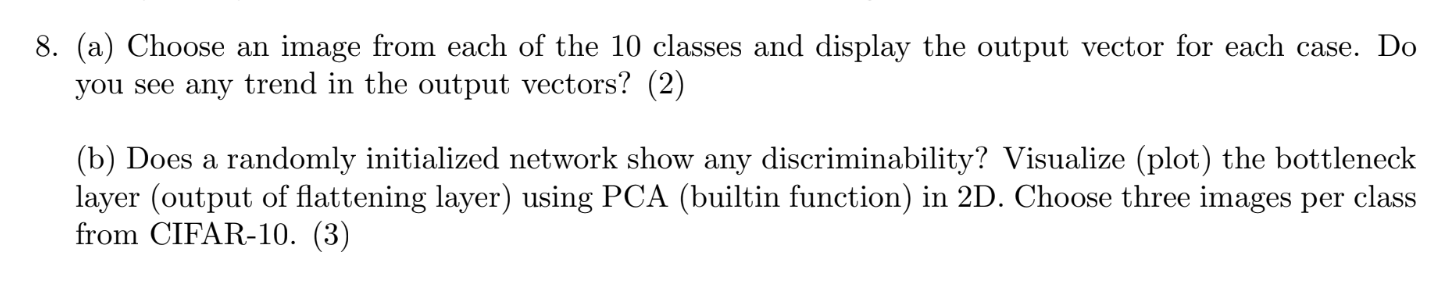

In [ ]:
# load dataset :
(trainX, trainy), (testX, testy) = cifar10.load_data()

def choose_k_img_per_class(k):
    """A helper function used to choose k images per class 
    and store them in a list. It returns the image list and corresponging label list"""
    
    label = 0
    i = 0
    ctr = 0
    image_list = []
    label_list = []
    # plot first few images
    while(label != 10):
        if(trainy[i] == label):
            image_list.append(trainX[i])
            label_list.append(trainy[i])
            ctr += 1
            if ctr == k:
                label += 1
                ctr = 0
        i += 1
        
    return image_list, label_list



In [ ]:
image_list, label_list = choose_k_img_per_class(1)
nn = feedForward()

j = 0
for image in image_list:
    conv_out = nn.convlayer1(image)
    pooled_out = nn.maxpoollayer1(conv_out)
    conv_out2 = nn.convlayer2(pooled_out)
    pooled_out2 = nn.maxpoollayer2(conv_out2)
    global_pool_out = nn.GAPlayer(pooled_out2) 
    final_op = nn.mlp(global_pool_out)
    
    # Displaying the output vector
    print(f"The final output vector of the image from class {j} is \n {final_op} \n")
    j += 1

## Ans 8(a) 
- Seeing the above values, there seems to be no trend in the output vectors of the images from all 10 classes. 
- However initialising the random weights from np.random.rand gives a trend in the sense that the pmfs in all the output vectors seems to be uniformly distributed 
- My initilisation is Xavier initialisation from the normal distribution. np.random.randn

## Ans 8 (b) 
- No, a randomly initialised network do not show any discriminability
- This is because all the weights and biases are randomly initialised

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
image_list2, label_list2 = choose_k_img_per_class(3)
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

N = 8
X = np.ones((30, N))

for i in range(len(image_list2)):
    nn = feedForward()
    conv_out = nn.convlayer1(image_list2[i])
    pooled_out = nn.maxpoollayer1(conv_out)
    conv_out2 = nn.convlayer2(pooled_out)
    pooled_out2 = nn.maxpoollayer2(conv_out2)
    X[i] = nn.GAPlayer(pooled_out2)
    
    
    
pca = PCA()    
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=label_list2)
plt.legend(handles=plot.legend_elements()[0], labels=labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.show()
    
    
    

    

## Notes on PCA :
- PC1 is the weights of the 8 variables(in this case) that describes the variation of the data best. 
- In interpretation, we can say, that PC1 is one new variable that describe your data best, if you wish to describe it with only one variable (generated from the 8 variables). 
- Note some of the 8 variables may not influence PC1 much (this will be indicated by a close to 0 value). Thus you do not need these variables to describe most of the variation in you data. 
- PC2 works similar. Only this is the new variable that explain the second most variation in you data.